# NVIDIA share price prediction

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from typing import Tuple
from numpy.typing import NDArray
from sklearn.preprocessing import MinMaxScaler

# Output directory for figures
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

## Data loading

In [2]:
# Load data
df = pd.read_csv('NVDA.csv')

# Convert date to datetime format and sort (just in case)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400
...,...,...,...,...,...,...,...
6111,2024-04-18,849.700012,861.900024,824.020020,846.710022,846.710022,44726000
6112,2024-04-19,831.500000,843.239990,756.059998,762.000000,762.000000,87190500
6113,2024-04-22,781.039978,800.729980,764.000000,795.179993,795.179993,59634100
6114,2024-04-23,807.690002,827.690002,802.640015,824.229980,824.229980,43855900


In [3]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6116 non-null   datetime64[ns]
 1   Open       6116 non-null   float64       
 2   High       6116 non-null   float64       
 3   Low        6116 non-null   float64       
 4   Close      6116 non-null   float64       
 5   Adj Close  6116 non-null   float64       
 6   Volume     6116 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 334.6 KB


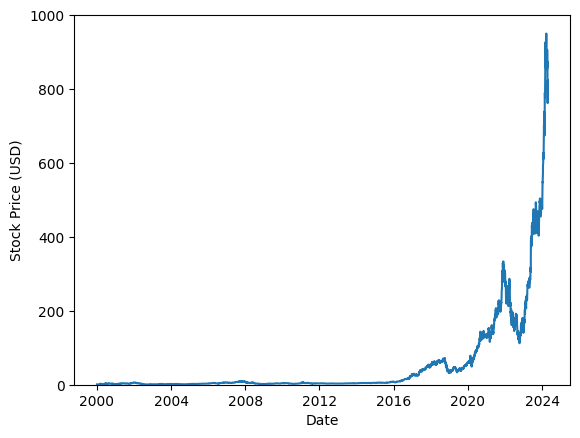

In [4]:
# Plot
sns.lineplot(df, x='Date', y='Close')
plt.ylabel('Stock Price (USD)')
plt.xlabel('Date')
plt.ylim([0, 1000])
plt.savefig(os.path.join(output_directory, '1_original_stock_price.png'),
            bbox_inches='tight', dpi=600)
plt.show()

## Data preparation

In [5]:
# Isolate relevant time period (the stock price is rather flat before 2017)
df_daily = df[df['Date'].dt.year >= 2017].copy()

# Set daily frequency and interpolate missing values
df_daily = df_daily.copy()
df_daily = df_daily.set_index('Date').asfreq('D')
df_daily = df_daily.interpolate(method='time', axis=0)
df_daily = df_daily.reset_index()

# Store time and price in Numpy arrays
time = df_daily.index.to_numpy(dtype=np.int32)
price = df_daily['Close'].to_numpy(dtype=np.float32)

df_daily

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,26.100000,26.592501,24.844999,25.502501,25.134892,1.501996e+08
1,2017-01-04,25.850000,26.375000,25.382500,26.097500,25.721306,1.199220e+08
2,2017-01-05,26.132500,26.455000,25.262501,25.434999,25.068359,9.842960e+07
3,2017-01-06,25.712500,26.062500,25.299999,25.775000,25.403461,8.228560e+07
4,2017-01-07,25.766667,26.375000,25.491666,26.123333,25.746772,8.539867e+07
...,...,...,...,...,...,...,...
2664,2024-04-20,814.679993,829.069987,758.706665,773.059998,773.059998,7.800503e+07
2665,2024-04-21,797.859985,814.899983,761.353333,784.119995,784.119995,6.881957e+07
2666,2024-04-22,781.039978,800.729980,764.000000,795.179993,795.179993,5.963410e+07
2667,2024-04-23,807.690002,827.690002,802.640015,824.229980,824.229980,4.385590e+07


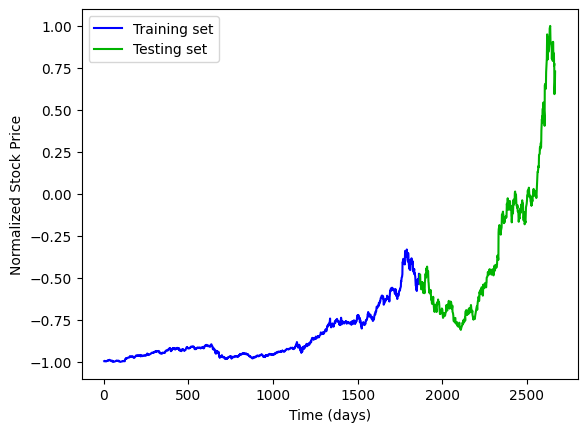

In [6]:
def generate_feature_target(data: NDArray,
                            lookback: int = 1) -> Tuple[NDArray, NDArray]:
    """
    Convert a data array into feature and target arrays
    """

    X, y = [], []
    for i in range(len(data) - lookback - 1):
        a = data[i:(i+lookback), 0]
        X.append(a)
        y.append(data[i + lookback, 0])

    return np.array(X), np.array(y)


# General parameters for below
lookback = 4
relative_train_size = 0.7

# Reshape and scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
price = price.reshape(-1, 1)
price = scaler.fit_transform(price)

# Prepare data for LSTM with lookback window
X, y = generate_feature_target(price, lookback)
time_lookback = time[lookback:-1]

# Split data into training and testing sets
idx_split = int(X.shape[0]*relative_train_size)
X_train, X_test = X[:idx_split, :], X[idx_split:, :]
y_train, y_test = y[:idx_split], y[idx_split:]
time_train, time_test = time_lookback[:idx_split], time_lookback[idx_split:]

# Final reshaping
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Plot
plt.plot(time_train, y_train[:, 0].numpy(), 'b', label='Training set')
plt.plot(time_test, y_test[:, 0].numpy(), color = [0, 0.7, 0], label='Testing set')
plt.ylabel('Normalized Stock Price')
plt.xlabel('Time (days)')
plt.legend()
plt.savefig(os.path.join(output_directory, '2_training_testing_sets.png'),
            bbox_inches='tight', dpi=600)
plt.show()

In [7]:
class timeseries(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y
        self.len = X.shape[0]

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return self.len


# Combine and store data
batch_size = 256

train_dataset = timeseries(X_train, y_train)
test_dataset = timeseries(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

## LSTM model definition and training

In [8]:
# Define model
class LSTM(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_stacked_layers: int,
                 fraction_dropout: float = 0.2) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Stacked LSTM layers
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_stacked_layers,
                            batch_first=True)
        
        # Fully connected layer after LSTM layers
        self.fc = nn.Linear(in_features=hidden_size,
                            out_features=1)
        
        # Define the fraction of neurons to dropout (to prevent overfitting)
        if (fraction_dropout < 0) or (fraction_dropout > 1):
            raise ValueError('fraction_dropout should be in [0, 1]')
        self.dropout = nn.Dropout(fraction_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)

        # Hidden and current data
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        
        # LSTM layers followed by fully connected layer
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])

        return out

In [9]:
torch.manual_seed(42)

# Model hyperparameters
hidden_size = 150
num_stacked_layers = 2
fraction_dropout = 0.25
model = LSTM(1, hidden_size, num_stacked_layers, fraction_dropout)

# Optimization hyperparameters
num_epochs = 50
learning_rate = 0.01
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_one_epoch():
    model.train(True)
    running_loss = 0.0
    
    print(f'Epoch: {epoch + 1}')
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        # Store the predictions and compute associated loss
        output = model(x_batch)
        loss: torch.Tensor = loss_function(output, y_batch)
        running_loss += loss.item()
        
        # Minimize loss via gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss values of the training set for each iteration
        if batch_index % 100 == 0:
            avg_loss_across_batches = running_loss/100
            print(f'Batch {batch_index+1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print('')


def test_one_epoch():
    model.train(False) # Make sure the model does not train on test data
    running_loss = 0.0

    for _, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]

        with torch.no_grad():
            output = model(x_batch)
            loss: torch.Tensor = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss/len(test_loader)

    print(f'Test Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')
    print()


for epoch in range(num_epochs):
    train_one_epoch()
    test_one_epoch()

Epoch: 1
Batch 1, Loss: 0.009

Test Loss: 0.428
***************************************************

Epoch: 2
Batch 1, Loss: 0.002

Test Loss: 0.575
***************************************************

Epoch: 3
Batch 1, Loss: 0.001

Test Loss: 0.837
***************************************************

Epoch: 4
Batch 1, Loss: 0.000

Test Loss: 0.739
***************************************************

Epoch: 5
Batch 1, Loss: 0.000

Test Loss: 0.728
***************************************************

Epoch: 6
Batch 1, Loss: 0.000

Test Loss: 0.683
***************************************************

Epoch: 7
Batch 1, Loss: 0.000

Test Loss: 0.583
***************************************************

Epoch: 8
Batch 1, Loss: 0.000

Test Loss: 0.463
***************************************************

Epoch: 9
Batch 1, Loss: 0.000

Test Loss: 0.267
***************************************************

Epoch: 10
Batch 1, Loss: 0.000

Test Loss: 0.043
******************************************

## LSTM model evaluation

In [11]:
with torch.no_grad():
    train_prediction = model(train_dataset.X).numpy()
    test_prediction = model(test_dataset.X).numpy()

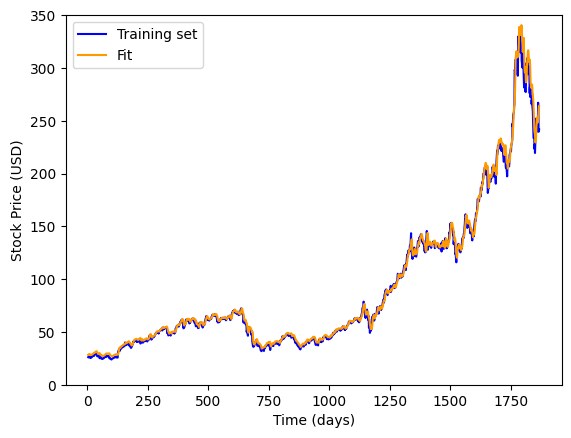

In [12]:
plt.plot(time_train, scaler.inverse_transform(y_train.numpy())[:, 0], 'b', label='Training set')
plt.plot(time_train, scaler.inverse_transform(train_prediction)[:, 0], color = [1, 0.6, 0], label='Fit')
plt.ylabel('Stock Price (USD)')
plt.xlabel('Time (days)')
plt.ylim([0, 350])
plt.legend()
plt.savefig(os.path.join(output_directory, '3_lstm_model_fit.png'),
            bbox_inches='tight', dpi=600)
plt.show()

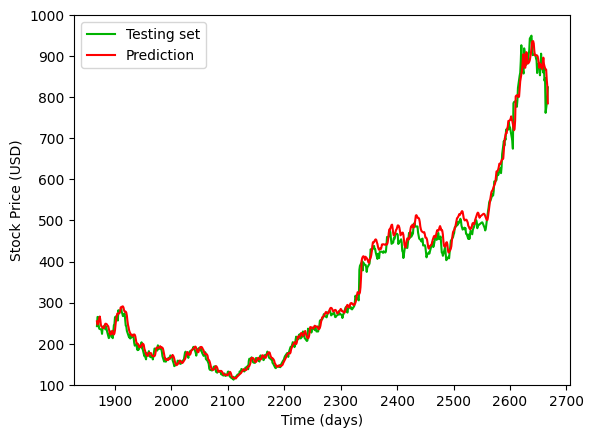

In [13]:
plt.plot(time_test, scaler.inverse_transform(y_test.numpy())[:, 0], color = [0, 0.7, 0], label='Testing set')
plt.plot(time_test, scaler.inverse_transform(test_prediction)[:, 0], 'r', label='Prediction')
plt.ylabel('Stock Price (USD)')
plt.xlabel('Time (days)')
plt.ylim([100, 1000])
plt.legend()
plt.savefig(os.path.join(output_directory, '4_lstm_model_prediction.png'),
            bbox_inches='tight', dpi=600)
plt.show()